In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scope import computations as cmp
from scope import clustering as cl
from scope import pre_match as pm
from scope import visualizations as vi
data=torch.load('embryo_rep.pt',weights_only=False)

In [3]:
import random
def setup_seed(seed: int = 42, deterministic: bool = False):

    random.seed(seed)
    
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.enabled = False  

seed = 42
setup_seed(seed=seed)

In [4]:
def remove_duplicates(tensor):
    unique_tensor = torch.unique(tensor, dim=0, return_inverse=False)
    return unique_tensor

data_lst = data['um']
data_lst_no_duplicates = [remove_duplicates(cells) for cells in data_lst]


def rep(day_list,high=500):
    day_list_new=[]
    for c in day_list:
        dif=high-c.shape[0]
        if dif>0:
            indice=torch.randint(0, c.size(0), (dif,))
            result=torch.cat([c,c[indice]],dim=0)
            day_list_new.append(result)
        else:
            day_list_new.append(c)     
    return day_list_new
 

# data_lst = rep(data_lst)
time_steps = [0,1,2,3,4,5,6,7,8,9,10,12,14,16]

meta=[[time_steps[i]]*len(data_lst[i]) for i in range(len(time_steps))]
meta=np.concatenate(meta)

In [5]:
max_variance_differences = cmp.max_adjacent_covariance_diagonal_differences([remove_duplicates(cells) for cells in data_lst])
print(max_variance_differences)
eps_func = cmp.piecewise_eps_function(time_steps, max_variance_differences,snr=0.9,min_eps=0.5) 

[0.005971173915629606, 0.00640080010383652, 1.0834361382319402, 1.827516616921954, 3.797834635327587, 4.4636375723136545, 0.5791272772820415, 2.2987567773115454, 1.805595282671737, 2.346076634777317, 8.988687556896089, 9.270964769777418, 16.2418944505661]


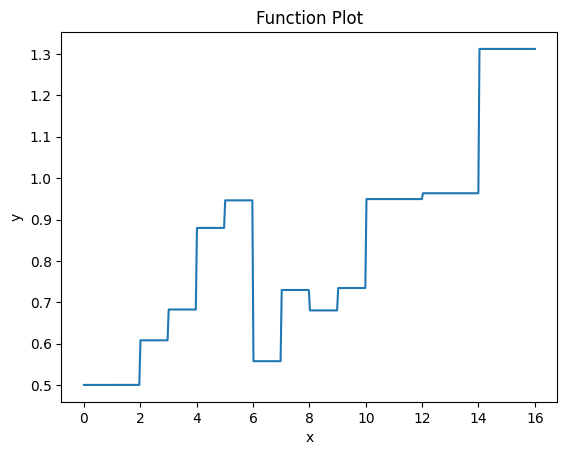

In [6]:
x = np.linspace(time_steps[0], time_steps[-1], 400)

y = [eps_func(x_i) for x_i in x]

plt.plot(x, y)

plt.title('Function Plot')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

In [7]:
import scope
from scope import model

steps_each_day = 8
steps = 16*steps_each_day
# eps = lambda t: np.exp(0.1 * t) 
eps = eps_func
eps_test = eps
sb_object=model.sb_muti_model(data_lst,time_steps,N_pretraining=400,N_finetuning=400,backbone_lr=1e-3,finetuning_lr=1e-3,hiden_size=32,n_layers=2,
                              steps=steps,eps=eps,early_stop=True,patience=32,B=128,lambda_=0,save=True,record_gap=2,save_path='model_history/embryo',prematched=False)

processed: 287:  72%|███████▏  | 287/400 [03:20<01:18,  1.43it/s, loss=212.7325564408409, loss_fore=214.62212431759653, loss_back=210.84298856408526] 


Early stopping at epoch 287


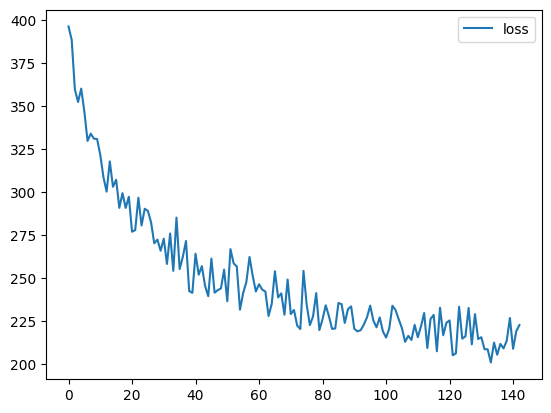

In [8]:
sb_object.backbone_train()

In [9]:
fore_base=sb_object.eval_fore(data_lst[0].cuda().double(),sb_object.v_fore)

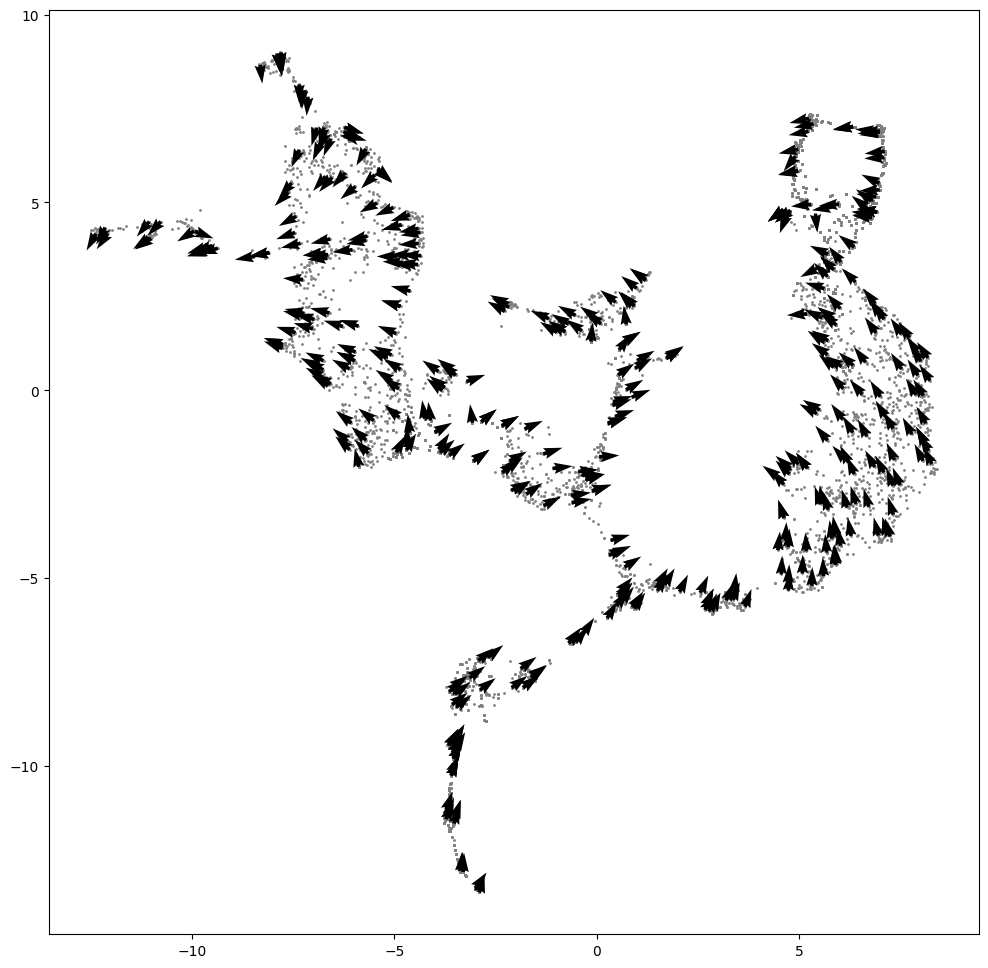

In [10]:
vi.visualize_drift_func([d.cuda() for d in data_lst],np.concatenate(data_lst),sb_object,meta,save_path='./embryo_results_no_prematch/drift_backbone',xg_lower_bound=-15,xg_upper_bound=10,yg_lower_bound=-15,yg_upper_bound=10)

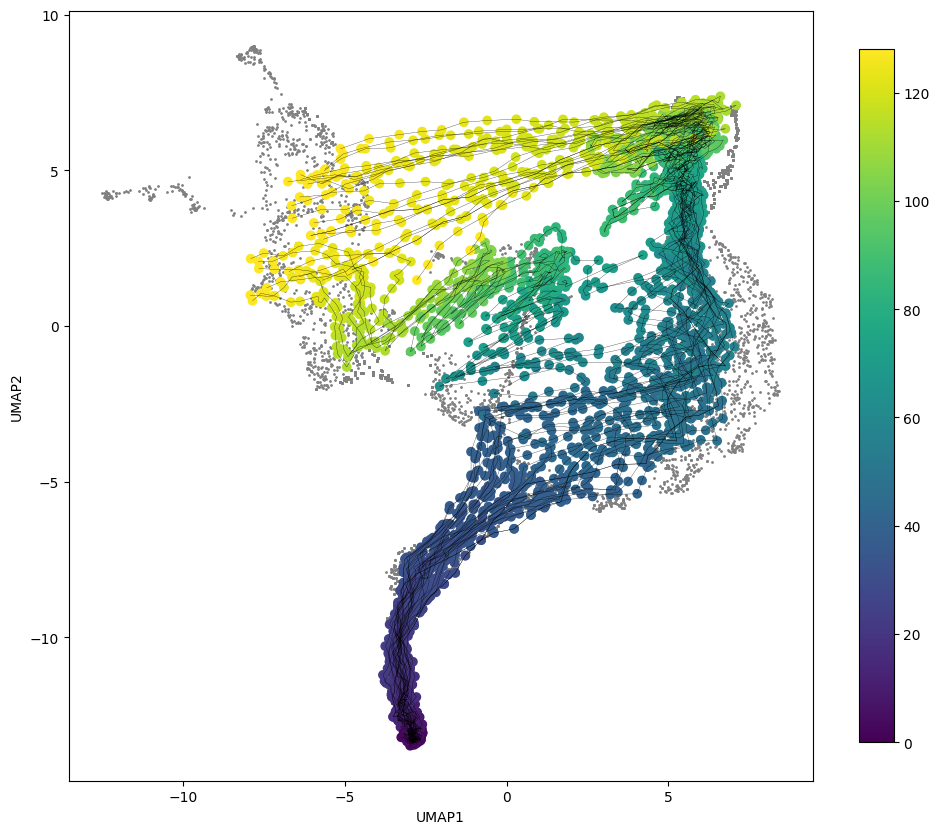

In [11]:
vi.visualize_generated_trajectories(data_lst,fore_base,save_path='./embryo_results_no_prematch/generated_trajectories_backbone')

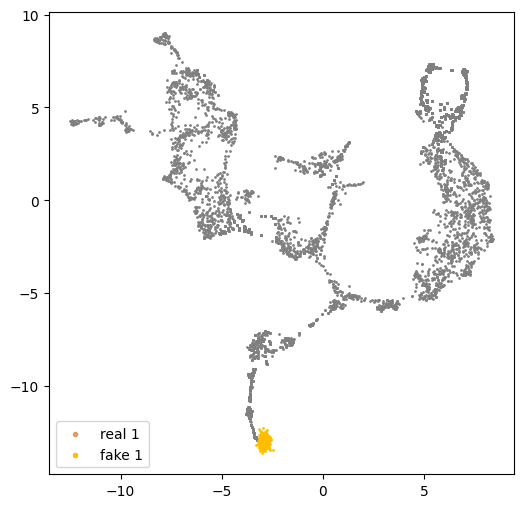

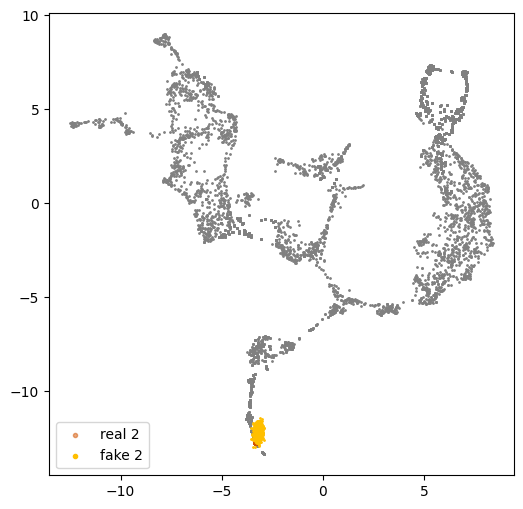

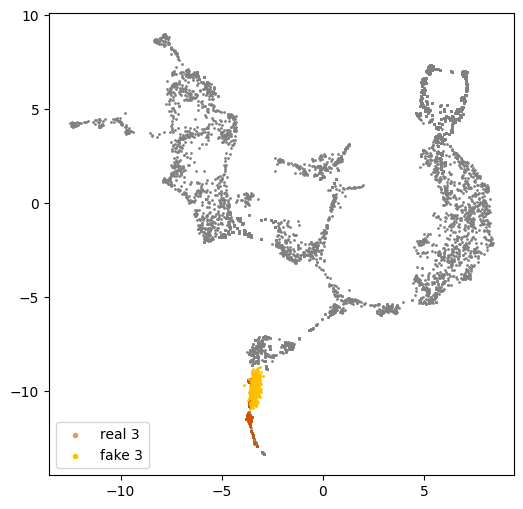

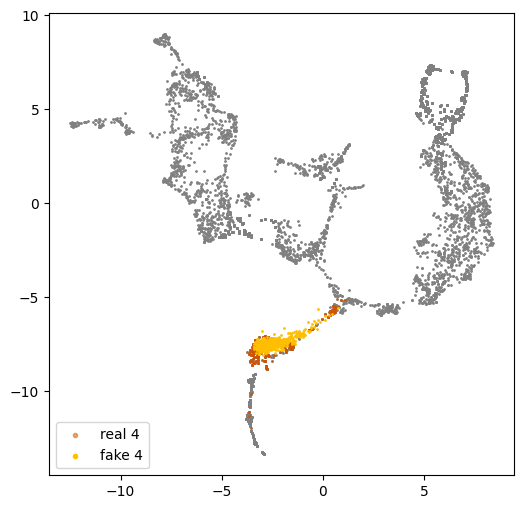

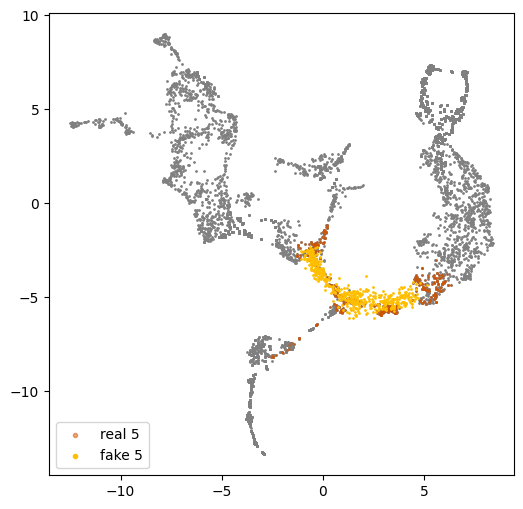

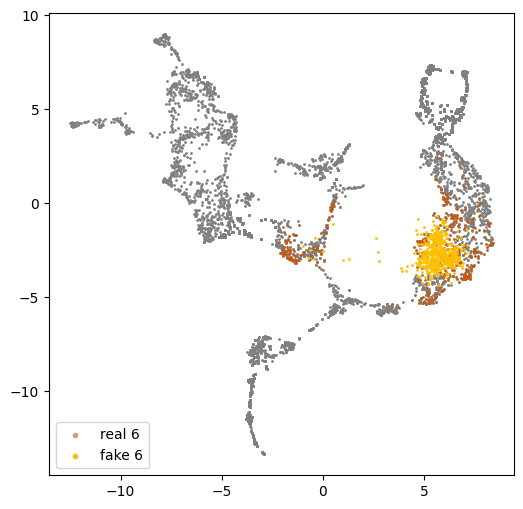

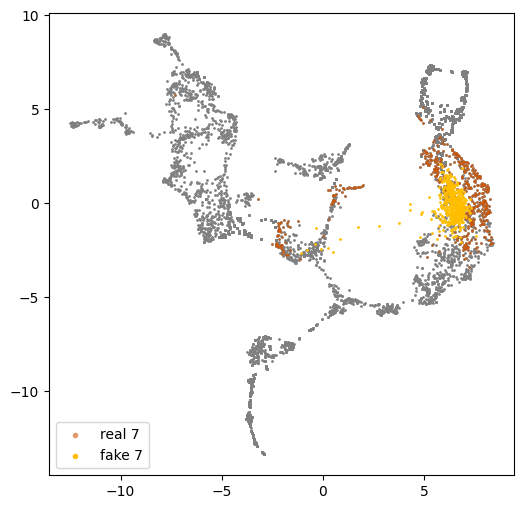

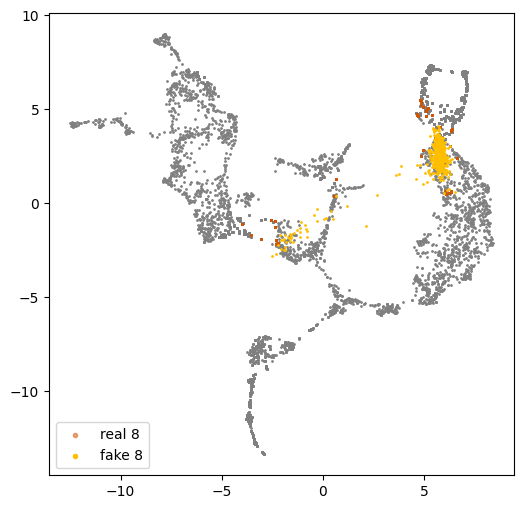

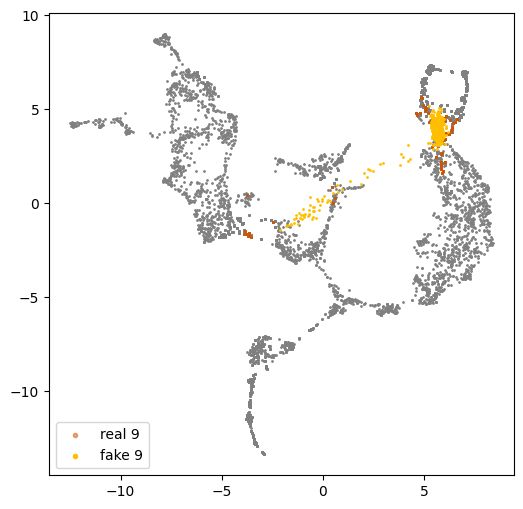

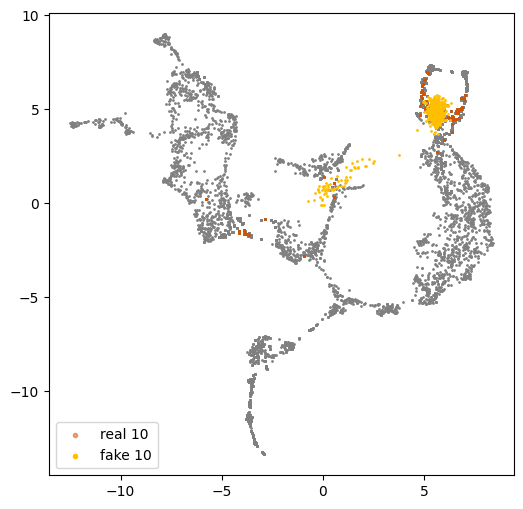

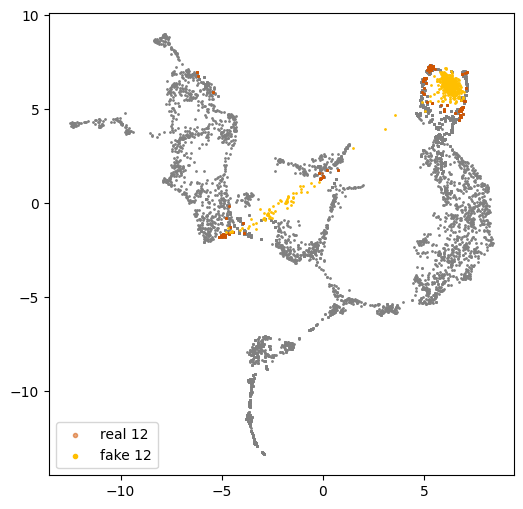

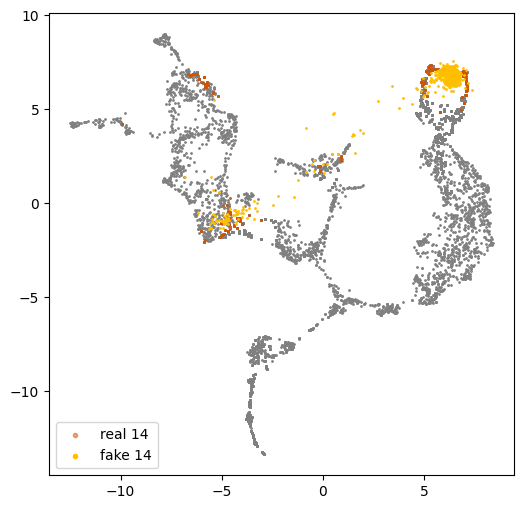

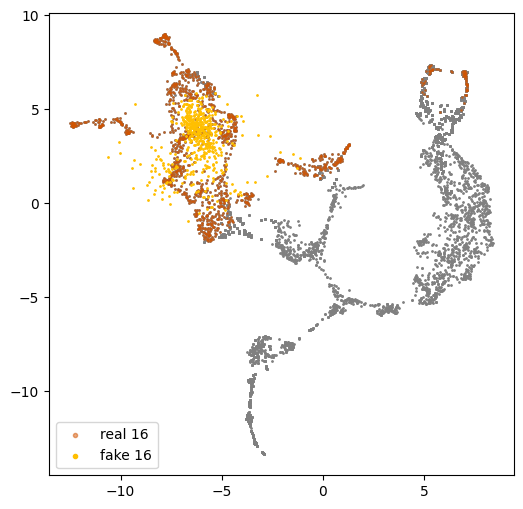

In [12]:
vi.visualize_generated_populations(data_lst,fore_base,time_steps,save_path='./embryo_results_no_prematch/generated_populations_backbone')

processed: 400: 100%|██████████| 400/400 [37:58<00:00,  5.70s/it, loss=30.964309552611937, loss_back=30.964309552611937]


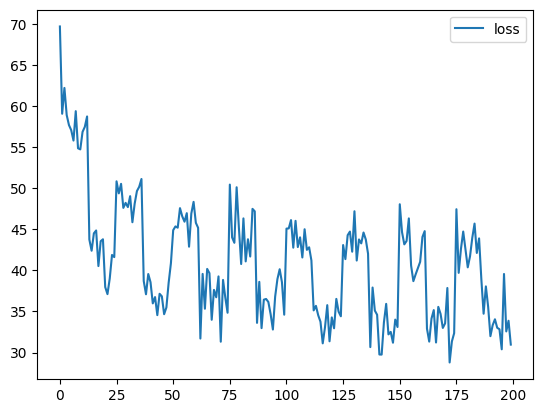

In [13]:
sb_object.fine_tune(change=25)
# sb_object.finetuning_load('model_history/embryo/fine_tuned.pt')

In [14]:
fore_ft=sb_object.eval_fore(data_lst[0].cuda().repeat(1,1).double(),sb_object.v_fore_fine_tuned)

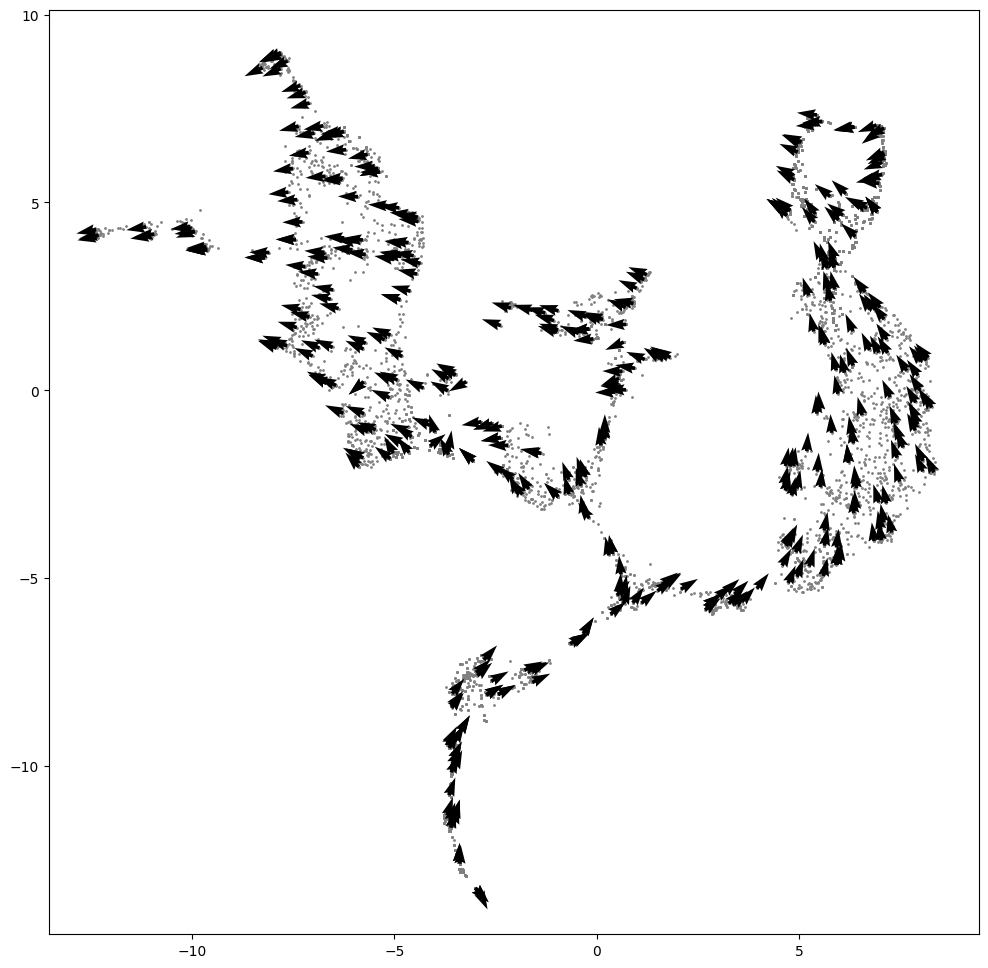

In [15]:
vi.visualize_drift_func(data_lst,np.concatenate(data_lst),sb_object,meta,save_path='./embryo_results_no_prematch/drift_fine_tuned',fine_tuned=True,xg_lower_bound=-15,xg_upper_bound=10,yg_lower_bound=-15,yg_upper_bound=10)

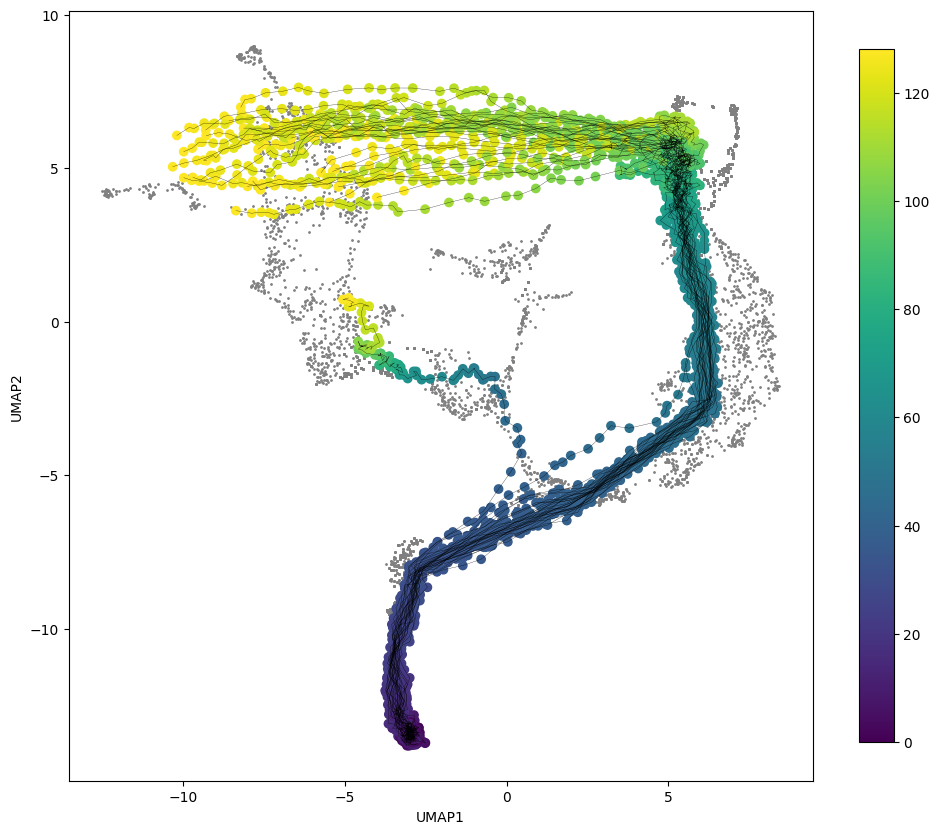

In [16]:
vi.visualize_generated_trajectories(data_lst,fore_ft,save_path='./embryo_results_no_prematch/generated_trajectories_fine_tuned')

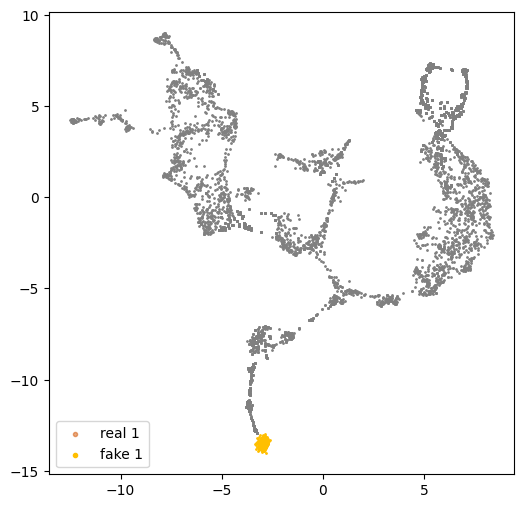

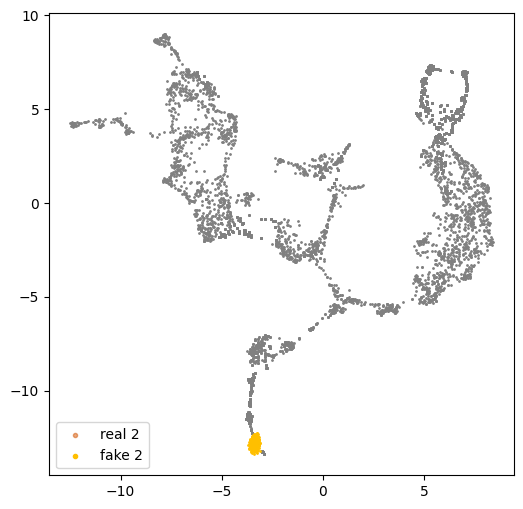

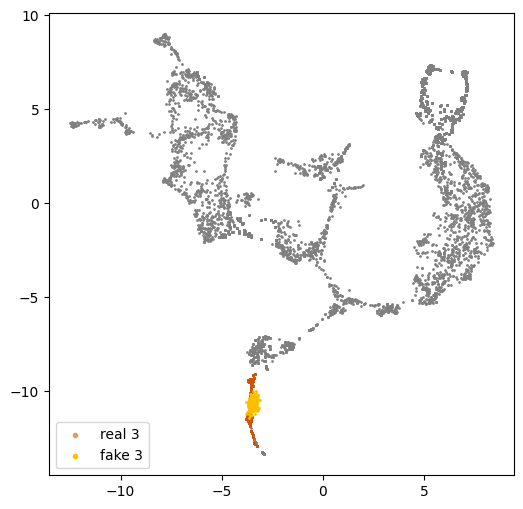

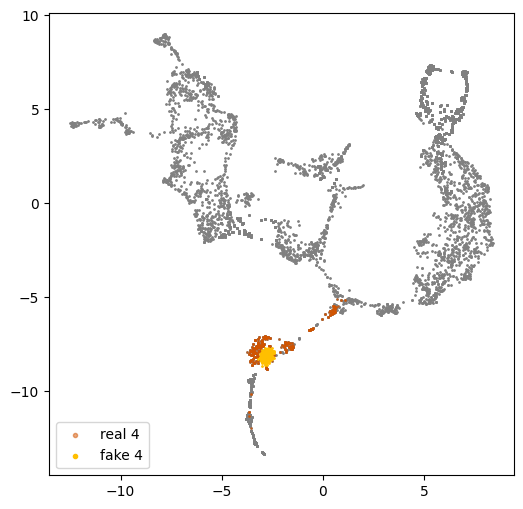

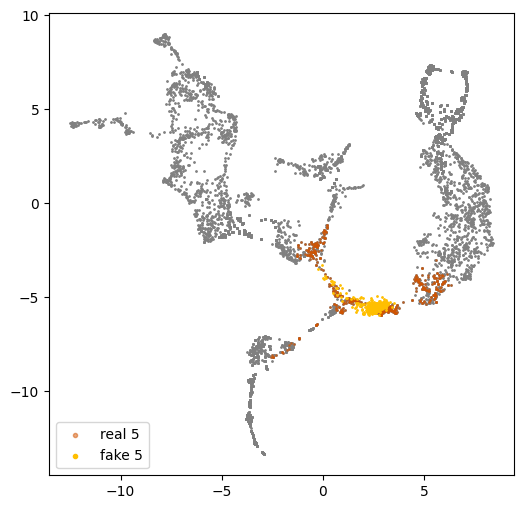

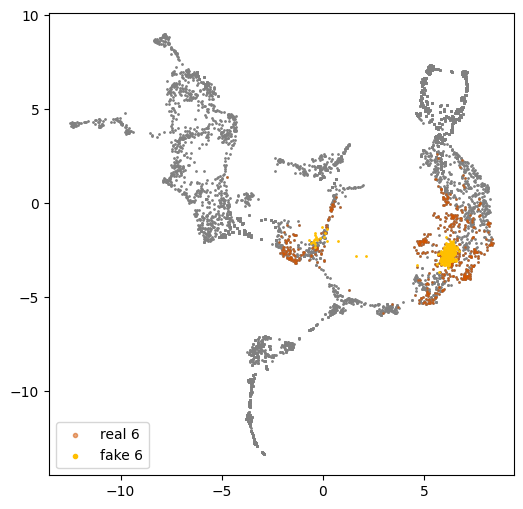

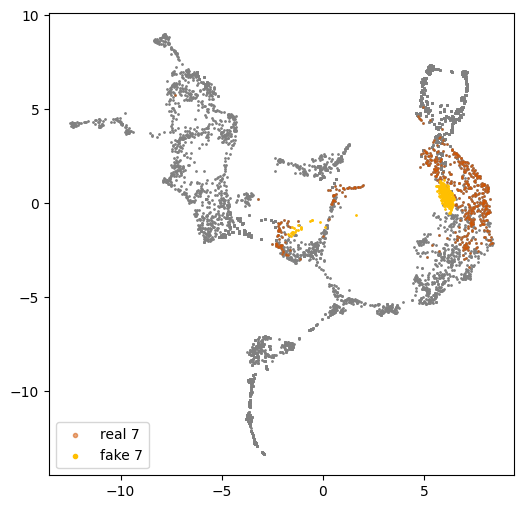

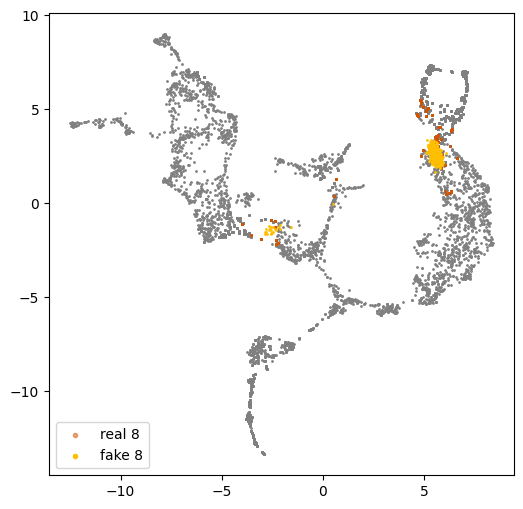

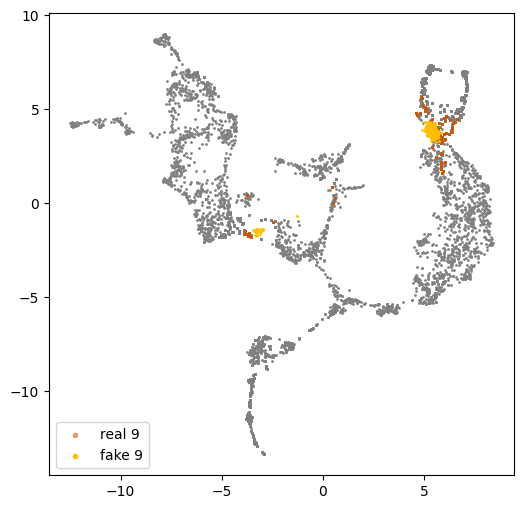

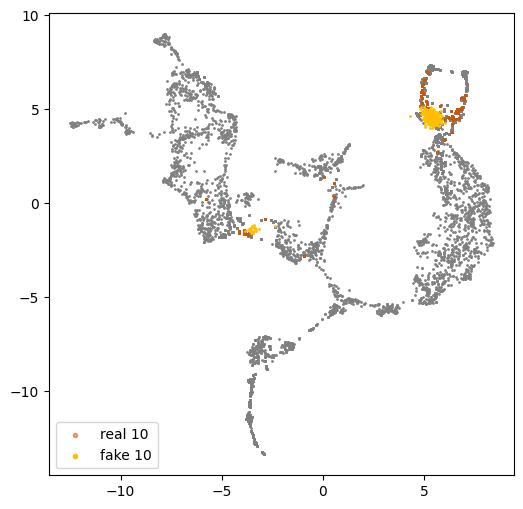

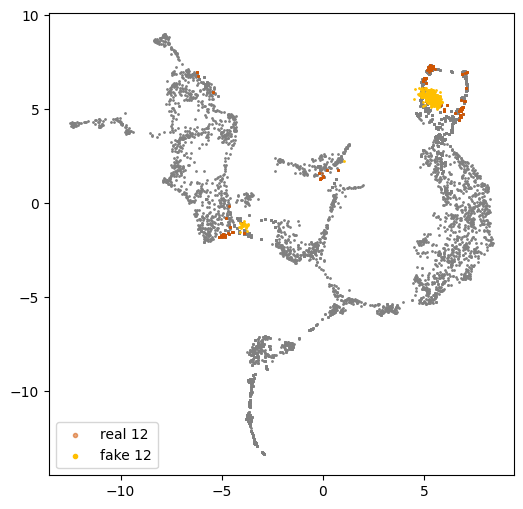

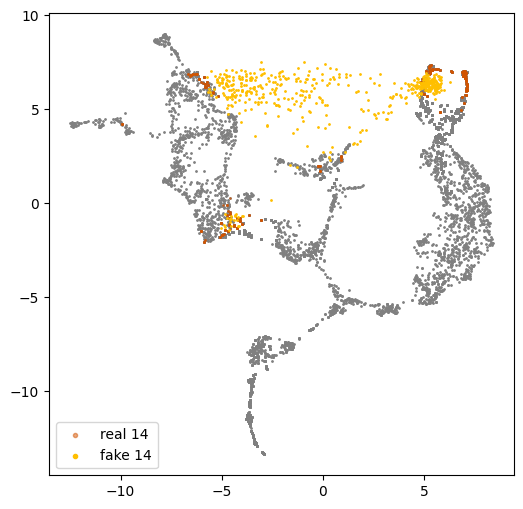

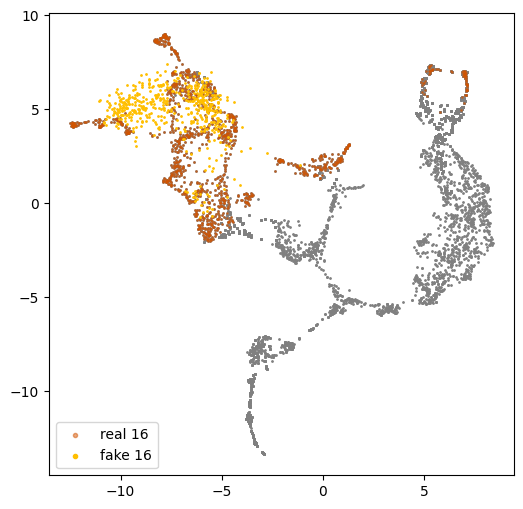

In [17]:
vi.visualize_generated_populations(data_lst,fore_ft,time_steps,save_path='./embryo_results_no_prematch/generated_populations_fine_tuned')

In [18]:
from geomloss import SamplesLoss
ot_solver = SamplesLoss("sinkhorn", p = 2, blur = 0.1, scaling = 0.7,backend='auto')

for week,data in enumerate(data_lst[1:]):
    data = torch.tensor(data, dtype=torch.float32).contiguous().cuda()
    back_bone_fake_data = torch.tensor(fore_base[time_steps[week+1]*steps_each_day], dtype=torch.float32).contiguous().cuda()
    print("backbone real" + str(time_steps[week+1]) + "-fake" + str(time_steps[week+1]),ot_solver(data, back_bone_fake_data).item())
    fine_tune_fake_data = torch.tensor(fore_ft[time_steps[week+1]*steps_each_day], dtype=torch.float32).contiguous().cuda()
    print("finetuned real" + str(time_steps[week+1]) + "-fake" + str(time_steps[week+1]),ot_solver(data, fine_tune_fake_data).item())

/tmp/ipykernel_16855/3531887930.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32).contiguous().cuda()
/tmp/ipykernel_16855/3531887930.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  back_bone_fake_data = torch.tensor(fore_base[time_steps[week+1]*steps_each_day], dtype=torch.float32).contiguous().cuda()
/tmp/ipykernel_16855/3531887930.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fine_tune_fake_data = torch.tensor(fore_ft[time_steps[week+1]*steps_each_day], dtype=torch.float32).con

backbone real1-fake1 0.06291937828063965
finetuned real1-fake1 0.04503936320543289
backbone real2-fake2 0.1942180097103119
finetuned real2-fake2 0.012525083497166634
backbone real3-fake3 0.6413683295249939
finetuned real3-fake3 0.37950724363327026
backbone real4-fake4 0.38879477977752686
finetuned real4-fake4 1.282275915145874
backbone real5-fake5 1.1412248611450195
finetuned real5-fake5 3.106675863265991
backbone real6-fake6 3.6867597103118896
finetuned real6-fake6 4.166569709777832
backbone real7-fake7 3.301657199859619
finetuned real7-fake7 2.789069652557373
backbone real8-fake8 2.2127602100372314
finetuned real8-fake8 3.3486692905426025
backbone real9-fake9 1.383880853652954
finetuned real9-fake9 2.442612409591675
backbone real10-fake10 3.6957597732543945
finetuned real10-fake10 4.375317573547363
backbone real12-fake12 9.162189483642578
finetuned real12-fake12 12.654718399047852
backbone real14-fake14 12.971392631530762
finetuned real14-fake14 6.283848762512207
backbone real16-fake